# Reto | Generación de un modelo inteligente de clasificación con redes neuronales profundas para la detección de amenazas aéreas

**Objetivos**:
El objetivo de este reto es poner en práctica los contenidos revisados durante el módulo realizando los siguientes pasos:

- Preparar una base de datos y generar los conjuntos de entrenamiento y prueba.
- Diseñar un modelo utilizando una red neuronal convolucional desde cero y determinar sus hiperparámetros.
- Diseñar un modelo utilizando una red neuronal convolucional utilizando un modelo pre-entrenado.
- Generar un modelo utilizando la herramienta Teachable Machine.
- Validar, evaluar y comparar los tres diferentes modelos generados y seleccionar el mejor considerando la exactitud como indicador de desempeño.
- Exportar los modelos generados para poder utilizarlos dentro de Colab o algún otro sitio.

## 1. Preprocesamiento de la base de datos

In [1]:
# Montando Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import pathlib
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import random
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
# Eliminando cualquiero archivo que no sea JPG, JPEG, PNG
!find /content/drive/MyDrive/Reto/datos/objetos -type f ! -name "*.jpg" ! -name "*.jpeg" ! -name "*.png" -delete


In [4]:
# Directorio base
dir_base = '/content/drive/MyDrive/Reto/datos/objetos'
dir_base = pathlib.Path(dir_base)
conteo_img = len(list(dir_base.glob('*/*')))
print('El total de imágenes es de:',conteo_img)


El total de imágenes es de: 8218


In [ ]:
# Correr si hay error al momento de entrenar el primer modelo
# for img_path in dir_base.rglob('*.[jp][pn]g'):
#     try:
#         img = tf.io.read_file(str(img_path))
#         img = tf.image.decode_image(img,channels=3)
#     except:
#         print('Error al decodificar:',img_path)
#         os.remove(img_path)

In [5]:
# Imágenes por clase
dir_base = '/content/drive/MyDrive/Reto/datos/objetos'
class_names = sorted(os.listdir(dir_base))

counts = {name: len(os.listdir(os.path.join(dir_base,name))) for name in class_names}
for clase,num in counts.items():
  print(f'La clase {clase} tiene {num} imágenes')

La clase avion tiene 1397 imágenes
La clase cohete tiene 1136 imágenes
La clase dron tiene 1290 imágenes
La clase helicoptero tiene 1328 imágenes
La clase jet tiene 1801 imágenes
La clase misil tiene 1266 imágenes


In [6]:
# Peso de las clases para balancear
total_muestras = 8218
class_weights = {
    0 : total_muestras / (6*counts['avion']), # Avion
    1 : total_muestras / (6*counts['cohete']), # Cohete
    2 : total_muestras / (6*counts['dron']), # Dron
    3 : total_muestras / (6*counts['helicoptero']), # Helicoptero
    4 : total_muestras / (6*counts['jet']), # Jet
    5 : total_muestras / (6*counts['misil']) # Misil
}

for clase, peso in class_weights.items():
  print(f'La clase {clase} tiene un peso de {peso:.4f}')

La clase 0 tiene un peso de 0.9804
La clase 1 tiene un peso de 1.2057
La clase 2 tiene un peso de 1.0618
La clase 3 tiene un peso de 1.0314
La clase 4 tiene un peso de 0.7605
La clase 5 tiene un peso de 1.0819


## 2. Generación de conjuntos de entrenamiento, prueba y aumentación de datos

### 2.1 Definición de Data Augmentation, Tamaño de la Imagen y Lote

Para generar el *data augmentation* se crea una secuencia de transformaciones aleatorias aplicadas a las imágenes durante el entrenamiento.
Este proceso ayuda a aumentar la variabilidad del conjunto de datos y mejorar la capacidad de generalización.

In [7]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.08),
    tf.keras.layers.RandomContrast(0.08),
    tf.keras.layers.RandomBrightness(0.08),
    tf.keras.layers.RandomTranslation(0.04, 0.04),
])

# Tamaño de las imágenes y lote
alto_img = 128
ancho_img = 128
tam_lote = 32

Para la creación de los conjuntos de entrenamiento y prueba se usará la función:

```
image_dataset_from_directory
```



In [8]:
# Definición del conjunto de entrenamiento
conj_entrenamiento = tf.keras.preprocessing.image_dataset_from_directory(
    dir_base,
    validation_split=0.2,
    subset='training',
    image_size=(alto_img,ancho_img),
    batch_size=tam_lote,
    seed = seed
)

# Definición del conjunto de prueba
conj_prueba = tf.keras.preprocessing.image_dataset_from_directory(
    dir_base,
    validation_split=0.2,
    subset='validation',
    image_size=(alto_img,ancho_img),
    batch_size=tam_lote,
    seed = seed
)
# Prefetch y Cache
conj_entrenamiento = (
    conj_entrenamiento
    .cache()
    .shuffle(1000,seed=seed)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

conj_prueba = (
    conj_prueba.
    cache().
    prefetch(buffer_size=tf.data.AUTOTUNE)
)


Found 8218 files belonging to 6 classes.
Using 6575 files for training.
Found 8218 files belonging to 6 classes.
Using 1643 files for validation.


## 3. Diseña una arquitectura de una red neuronal convolucional profunda desde cero para resolver el problema de clasificación


In [ ]:
from tensorflow.keras import regularizers
# Definición del primer modelo
redConv = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(alto_img,ancho_img,3)),
    tf.keras.layers.Rescaling(1/255),

    # Data Augmentation
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.08),
    tf.keras.layers.RandomContrast(0.08),
    tf.keras.layers.RandomTranslation(0.08,0.08),

    # Convoluciones
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),


    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.35),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(256,activation='relu',
                          kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128,activation='relu',
                          kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(6,activation='softmax')
])
redConv.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_5 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_5               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_5 (RandomZoom)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_5               │ (None, 128, 128, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 31, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 31, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 489,798 (1.87 MB)

 Trainable params: 488,838 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

A continuación, se configura el modelo para entrenamiento, así mismo, se define el optimizador, la función de pérdida y métricas de evaluación.
Además, se implementan **callbacks** para que ayuden a mejorar la eficiencia y estabilidad del entrenamiento.

In [ ]:
# Compilación del modelo
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

opt = Adam(learning_rate=1e-4)

redConv.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# LR
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

## 4. Diseña una arquitectura de una red neuronal convolucional profunda que utilice como base un modelo pre-entrenado para resolver el problema de clasificación

### 4.1 MobileNetV2

Al usar un modelo pre-entrenado se usará:

```
MobileNetV2
```
Así mismo, para evitar que los ecosistemas tengan problemas, se utilizarán pesos predefinidos.



In [ ]:
# Configurar modelo pre-entrenado
forma_img = (128,128,3)
modelo_base = tf.keras.applications.MobileNetV2(
    input_shape = forma_img,
    include_top = False,
    weights='imagenet'
)
modelo_base.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Es importante normalizar los datos de entrada en la base convolucional.

In [ ]:
from tensorflow.keras import regularizers
# Modelo completo
inputs = tf.keras.Input(shape=forma_img)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = modelo_base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
modelo_pre = tf.keras.Model(inputs, outputs)
modelo_pre.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 4.2 Modelo Preentreado EfficientNetB0

In [ ]:
modelo_base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(128,128,3)
)

modelo_base.trainable = False

In [ ]:
from tensorflow.keras import regularizers
# Modelo Completo
inputs = tf.keras.Input(shape=(128,128,3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = modelo_base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(6,activation='softmax')(x)
modelo_completo = tf.keras.Model(inputs,outputs)
modelo_completo.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Compilación del modelo
opt = Adam(learning_rate=1e-4)
modelo_completo.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_acuraccy',
    patience=5,
    verbose=1,
    restore_best_weights=True,
    mode='max'
)

## 5. Modelo con Teachable Machine
Para la generación del modelo en Teachable Machine se declararán 6 clases:
1. Misil
2. Jet
3. Helicóptero
4. Dron
5. Cohete
6. Avión

Para la creación del modelo se eligirán las primeras 200 imágenes de cada clase.

Los hiperparámetros serán los siguientes:

- Épocas: 50
- Tamaño del lote: 32
- Tasa de aprendizaje : 0.001

Como Teachable Machine trabaja con imágenes de 224x224x3 se hará un proceprocesamiento para que se puedan evaluar las imágenes de 128x128. Esto consiste en convertir las imágenes de 128x128 a 224x224 sin afectar las carpetas originales.

In [14]:
# Cargar modelo
modelo_TM = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_TM.keras')

# Ruta
dir_base = '/content/drive/MyDrive/Reto/datos/objetos'
path = pathlib.Path(dir_base)

# Extensiones
extensiones = ('.jpg','.jpeg','.png')
class_names = sorted([d.name for d in path.iterdir() if d.is_dir()])


# Función para crear lista de ruta y etiqueta
def get_image_label_list(path,class_names):
    image_paths = []
    labels = []
    for idx, class_name in enumerate(class_names):
        class_folder = path/class_name
        for f in class_folder.iterdir():
            if f.suffix.lower() in extensiones:
                image_paths.append(str(f))
                labels.append(idx)
    return image_paths, labels
image_paths,labels = get_image_label_list(path,class_names)

def preprocess(path,label):
    img = tf.io.read_file(path)
    # Detectar formato por extension
    ext = tf.strings.lower(tf.strings.split(path,'.')[-1])
    # Decodificar imagen
    def decode_jpg(): return tf.image.decode_jpeg(img,channels=3)
    def decode_jpg(): return tf.image.decode_jpeg(img,channels=3)
    def decode_png(): return tf.image.decode_png(img,channels=3)
    img = tf.case([
        (tf.equal(ext,'jpg'),decode_jpg),
        (tf.equal(ext,'jpeg'),decode_jpg),
        (tf.equal(ext,'png'),decode_png)
    ])
    img = tf.image.convert_image_dtype(img,tf.float32)
    img = tf.image.resize(img,(224,224))
    return img, label

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((image_paths,labels))
dataset = dataset.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 320 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
len(image_paths)

8218

## 6. Entrena y ajusta las arquitecturas diseñadas

### 6.1 Primer Modelo

In [ ]:
# Entrenamiento del modelo
evolucion = redConv.fit(
    conj_entrenamiento,
    validation_data = conj_prueba,
    epochs = 50,
    callbacks = [early_stopping,reduce_lr],
    class_weight = class_weights
 )

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.1932 - loss: 2.0657 - val_accuracy: 0.1284 - val_loss: 2.0222 - learning_rate: 1.0000e-04
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.2301 - loss: 1.8121 - val_accuracy: 0.1759 - val_loss: 1.9152 - learning_rate: 1.0000e-04
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.2627 - loss: 1.7663 - val_accuracy: 0.2824 - val_loss: 1.7264 - learning_rate: 1.0000e-04
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.2820 - loss: 1.7389 - val_accuracy: 0.2788 - val_loss: 1.7087 - learning_rate: 1.0000e-04
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.2976 - loss: 1.7238 - val_accuracy: 0.2921 - val_loss: 1.6956 - learning_rate: 1.0000e-04
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.3028 - loss: 1.7044 - val_accuracy: 0.3104 - val_loss: 1.6756 - learning_rate: 1.0000e-04
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/ste

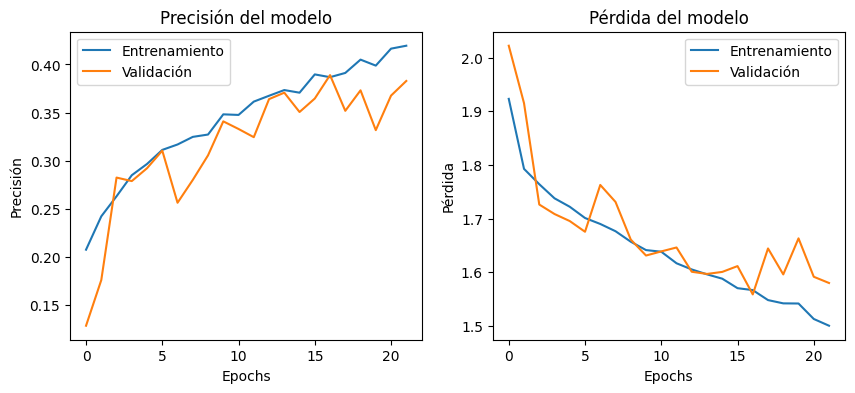

In [ ]:
# Gráfico de la evolución de entrenamiento y pérdida
# Historial de entrenamiento
hist = evolucion.history
plt.figure(figsize=(10,4))

# Presición del modelo
plt.subplot(1,2,1)
plt.plot(hist['accuracy'],label='Entrenamiento')
plt.plot(hist['val_accuracy'],label='Validación')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.title('Precisión del modelo')
plt.legend()

# Pérdida del modelo
plt.subplot(1,2,2)
plt.plot(hist['loss'],label='Entrenamiento')
plt.plot(hist['val_loss'],label='Validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.title('Pérdida del modelo')
plt.legend()

plt.show()

### 6.2 Modelo Preentrenado MobileNetV2 con Fine-Tuning

**Fine-Tuning** es una técnica que aprovecha un modelo preentrenado para ajustar los pesos para adaptarlo a un nuevo problema.

Las principales ventajas son:
1. Aprovecha conocimiento previo
2. Requiere menos datos y tiempo
3. Mejora la precisión
4. Evita el sobreajuste.

In [ ]:
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=1,
    restore_best_weights=True,
)
# Reducir Learning Rate
lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-5
)

# Compilar modelo final
modelo_pre.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)


Se entrenará el clasificador con el modelo base congelado, posteriormente, se hará fine-tuning, descongelando las últimas capas de MobileNetV2 para obtener mejores resultados.

In [ ]:
# Entrenamiento
print('Fase 1: Base Congelada')
historial_1 = modelo_pre.fit(
    conj_entrenamiento,
    epochs=15,
    validation_data = conj_prueba,
    callbacks = [early_stopping,lr],
    class_weight = class_weights
)

Fase 1: Base Congelada
Epoch 1/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 2761s 3s/step - accuracy: 0.2740 - loss: 1.8340 - val_accuracy: 0.4985 - val_loss: 1.3391 - learning_rate: 1.0000e-04
Epoch 2/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 152s 737ms/step - accuracy: 0.4572 - loss: 1.3790 - val_accuracy: 0.5526 - val_loss: 1.2081 - learning_rate: 1.0000e-04
Epoch 3/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 198s 722ms/step - accuracy: 0.5234 - loss: 1.2182 - val_accuracy: 0.5758 - val_loss: 1.1505 - learning_rate: 1.0000e-04
Epoch 4/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 146s 708ms/step - accuracy: 0.5193 - loss: 1.1943 - val_accuracy: 0.5898 - val_loss: 1.1041 - learning_rate: 1.0000e-04
Epoch 5/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 210s 747ms/step - accuracy: 0.5586 - loss: 1.1321 - val_accuracy: 0.6032 - val_loss: 1.0700 - learning_rate: 1.0000e-04
Epoch 6/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 145s 703ms/step - accuracy: 0.5874 - loss: 1.0937 - val_accuracy: 0.6141 - val_loss: 1.0489 - learning_rate: 1.0000e-04
Epoch 7/15
206/206 

In [ ]:
print('Fase 2: Fine-Tuning')

# Fine-Tuning
modelo_base.trainable = True

# Se entrenarán las últimas 30 capas
for layer in modelo_base.layers[:-30]:
    layer.trainable = False

# Compilación del modelo
modelo_pre.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-6,weight_decay=1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
# Entrenamiento
historia_2 = modelo_pre.fit(
    conj_entrenamiento,
    epochs=30,
    validation_data = conj_prueba,
    callbacks = [early_stopping,lr]
)

Fase 2: Fine-Tuning
Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 157s 724ms/step - accuracy: 0.6600 - loss: 0.9245 - val_accuracy: 0.6324 - val_loss: 0.9856 - learning_rate: 5.0000e-06
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 197s 702ms/step - accuracy: 0.6672 - loss: 0.8958 - val_accuracy: 0.6342 - val_loss: 0.9883 - learning_rate: 5.0000e-06
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 146s 707ms/step - accuracy: 0.6663 - loss: 0.8880 - val_accuracy: 0.6318 - val_loss: 0.9877 - learning_rate: 5.0000e-06
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 205s 723ms/step - accuracy: 0.6636 - loss: 0.9008 - val_accuracy: 0.6324 - val_loss: 0.9879 - learning_rate: 5.0000e-06
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 145s 705ms/step - accuracy: 0.6691 - loss: 0.8879 - val_accuracy: 0.6312 - val_loss: 0.9873 - learning_rate: 5.0000e-06
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 149s 724ms/step - accuracy: 0.6584 - loss: 0.8957 - val_accuracy: 0.6306 - val_loss: 0.9882 - learning_rate: 5.0000e-06
Epoch 7/30
206/206 ━

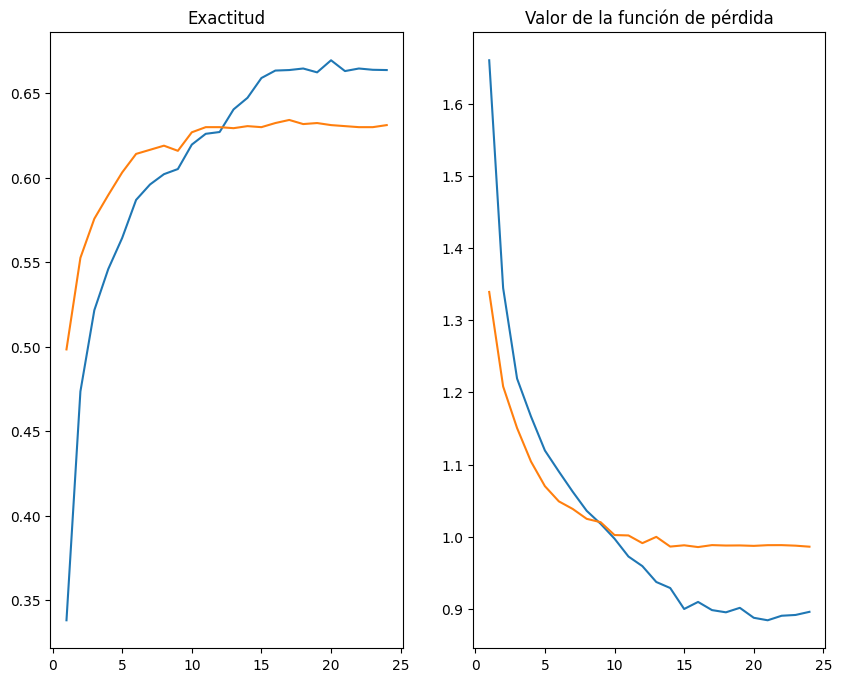

In [ ]:
# Combinando historiales
acc = historial_1.history['accuracy'] + historia_2.history['accuracy']
val_acc = historial_1.history['val_accuracy'] + historia_2.history['val_accuracy']

loss = historial_1.history['loss'] + historia_2.history['loss']
val_loss = historial_1.history['val_loss'] + historia_2.history['val_loss']

epochs = range(1, len(acc) + 1)

# Gráfica de la evolución de entrenamiento y pérdida
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(epochs,acc,label='Exactitud Entrenamiento')
plt.plot(epochs,val_acc,label='Exactitud Validación')
plt.title('Exactitud')

plt.subplot(1,2,2)
plt.plot(epochs,loss,label='Perdida Entrenamiento')
plt.plot(epochs,val_loss,label='Perdida Validación')
plt.title('Valor de la función de pérdida')

plt.show()

### 6.3 Modelo Preentrenado EfficientNetB0 con Fine-Tuning

In [ ]:
# Entrenamiento
print('Fase 1: Base Congelada')
historial_1 = modelo_completo.fit(
    conj_entrenamiento,
    validation_data=conj_prueba,
    epochs=15,
    callbacks=[early_stopping],
    class_weight = class_weights
)

Fase 1: Base Congelada
Epoch 1/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 2187s 3s/step - accuracy: 0.2122 - loss: 1.8537 - val_accuracy: 0.4114 - val_loss: 1.5445
Epoch 2/15
  5/206 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3490 - loss: 1.6326

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_acuraccy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3532 - loss: 1.6068 - val_accuracy: 0.4942 - val_loss: 1.3763
Epoch 3/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.4172 - loss: 1.4816 - val_accuracy: 0.5478 - val_loss: 1.2821
Epoch 4/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.4570 - loss: 1.3942 - val_accuracy: 0.5642 - val_loss: 1.2234
Epoch 5/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.4815 - loss: 1.3506 - val_accuracy: 0.5776 - val_loss: 1.1825
Epoch 6/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.4985 - loss: 1.2935 - val_accuracy: 0.5837 - val_loss: 1.1538
Epoch 7/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.5316 - loss: 1.2469 - val_accuracy: 0.5940 - val_loss: 1.1313
Epoch 8/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.5189 - loss: 1.2420 - val_accuracy: 0.6038 - val_loss: 1.1143
Epoch 9/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5299 - loss: 1.2345 - val_accuracy: 0.608

In [ ]:
# Fine- Tuning
modelo_base.trainable = True

# Descongelando las últimas 40 capas
for layer in modelo_base.layers[:-40]:
    layer.trainable = False


# Cosine Decay
initial_lr = 1e-4
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts (
    initial_learning_rate=initial_lr,
    first_decay_steps = 15,
    t_mul = 2,
    m_mul = 0.8,
)
opt_finetune = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compilación del modelo
modelo_completo.compile(
    optimizer = opt_finetune,
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True,
    mode='max'
)

# Entrenamiento
print('Fase 2: Fine-Tuning')
historia_2 = modelo_completo.fit(
    conj_entrenamiento,
    validation_data=conj_prueba,
    epochs=30,
    callbacks=[early_stopping],
    class_weight = class_weights
)

Fase 2: Fine-Tuning
Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.5068 - loss: 1.2708 - val_accuracy: 0.6044 - val_loss: 1.0518
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5637 - loss: 1.1509 - val_accuracy: 0.6093 - val_loss: 1.0373
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.5768 - loss: 1.1056 - val_accuracy: 0.6226 - val_loss: 1.0102
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.5769 - loss: 1.0943 - val_accuracy: 0.6275 - val_loss: 0.9938
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.6161 - loss: 1.0247 - val_accuracy: 0.6275 - val_loss: 0.9862
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.6130 - loss: 1.0081 - val_accuracy: 0.6330 - val_loss: 0.9679
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.6395 - loss: 0.9697 - val_accuracy: 0.6385 - val_loss: 0.9558
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.6390 

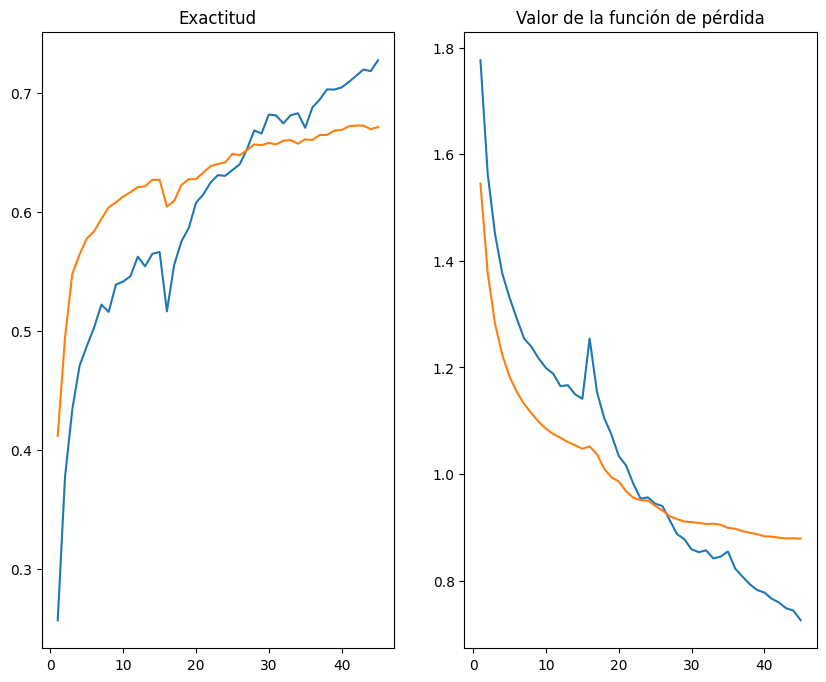

In [ ]:
# Combinando historiales
acc = historial_1.history['accuracy'] + historia_2.history['accuracy']
val_acc = historial_1.history['val_accuracy'] + historia_2.history['val_accuracy']

loss = historial_1.history['loss'] + historia_2.history['loss']
val_loss = historial_1.history['val_loss'] + historia_2.history['val_loss']

epochs = range(1, len(acc) + 1)

# Gráfica de la evolución de entrenamiento y pérdida
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(epochs,acc,label='Exactitud Entrenamiento')
plt.plot(epochs,val_acc,label='Exactitud Validación')
plt.title('Exactitud')

plt.subplot(1,2,2)
plt.plot(epochs,loss,label='Perdida Entrenamiento')
plt.plot(epochs,val_loss,label='Perdida Validación')
plt.title('Valor de la función de pérdida')

plt.show()
plt.show()

## 7. Exportación de Modelos

### 7.1 Primer Modelo

In [ ]:
# Guardar modelo
redConv.save('/content/drive/MyDrive/Reto/modelo_redConv.keras')


In [18]:
# Cargar modelo
modelo_redConv = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_redConv.keras')

### 7.2 Modelo pre-entrenado MobileNetV2

In [ ]:
# Guardar modelo
modelo_pre.save('/content/drive/MyDrive/Reto/modelo_pre.keras')

In [19]:
# Cargar modelo
modelo_prentrenado = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_pre.keras')

### 7.3 Modelo preentrenado EfficientNetB0

In [ ]:
# Guardar modelo
modelo_completo.save('/content/drive/MyDrive/Reto/modelo_completoB0.keras')


In [20]:
# Cargar modelo
modelo_prentrenado_B0 = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_completoB0.keras')

## 8. Comparativa de los tres modelos generados en el problema de clasificación

### 8.1 Evaluación del Primer Modelo

In [21]:
# Pérdida y Exactitud
loss_redConv, acc_redConv = modelo_redConv.evaluate(conj_prueba)
print(f' Pérdida del modelo: {loss_redConv:.4f}')
print(f' Exactitud del modelo: {acc_redConv:.4f}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 250ms/step - accuracy: 0.3638 - loss: 1.5746
 Pérdida del modelo: 1.5589
 Exactitud del modelo: 0.3889


### 8. 2 Evaluación del Modelo Preentrenado MobileNetV2

In [22]:
loss_pre, acc_pre = modelo_prentrenado.evaluate(conj_prueba)
print(f' Pérdida del modelo pre-entrenado: {loss_pre:.4f}')
print(f' Exactitud del modelo pre-entrenado: {acc_pre:.4f}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6201 - loss: 1.0210
 Pérdida del modelo pre-entrenado: 0.9856
 Exactitud del modelo pre-entrenado: 0.6324


### 8. 3 Evaluación del Modelo Preentrenado EfficientNetB0

In [23]:
loss_eff, acc_eff = modelo_prentrenado_B0.evaluate(conj_prueba)
print(f' Pérdida del modelo pre-entrenado: {loss_eff:.4f}')
print(f' Exactitud del modelo pre-entrenado: {acc_eff:.4f}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6528 - loss: 0.9151
 Pérdida del modelo pre-entrenado: 0.8807
 Exactitud del modelo pre-entrenado: 0.6726


### 8.4 Evaluación del modelo de Teachable Machine

In [16]:
loss_TM, acc_TM = modelo_TM.evaluate(dataset)
print(f' Pérdida del modelo: {loss_TM:.4f}')
print(f' Exactitud del modelo: {acc_TM:.4f}')

257/257 ━━━━━━━━━━━━━━━━━━━━ 106s 407ms/step - accuracy: 0.5398 - loss: 2.8896
 Pérdida del modelo: 2.9628
 Exactitud del modelo: 0.5326


### 7.4 Comparación de los tres modelos

#### 7.4.1 Comparación de exactitudes

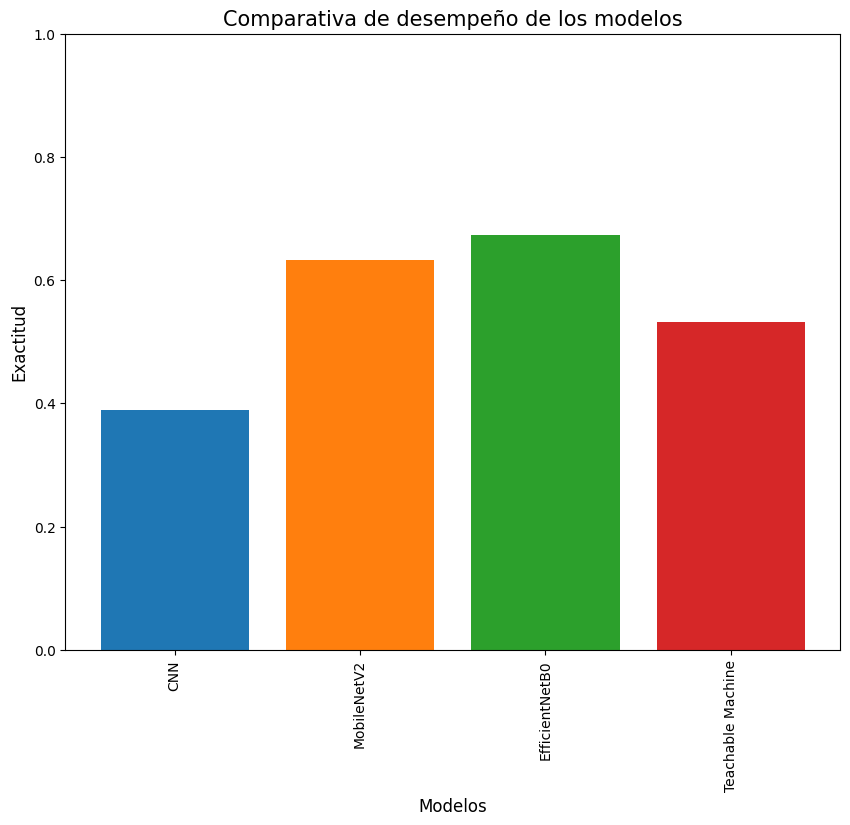

In [26]:
exactitudes = [acc_redConv,acc_pre,acc_eff,acc_TM]
modelos = ['CNN','MobileNetV2',
           'EfficientNetB0','Teachable Machine']
colors = ['tab:blue','tab:orange','tab:green','tab:red']
plt.figure(figsize=(10,8))
plt.bar(modelos,exactitudes,color=colors)
plt.ylim(0,1)
plt.xlabel('Modelos',fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Exactitud',fontsize=12)
plt.title('Comparativa de desempeño de los modelos',fontsize=15)
plt.show()

#### 7.4.2 Comparación de pérdidas

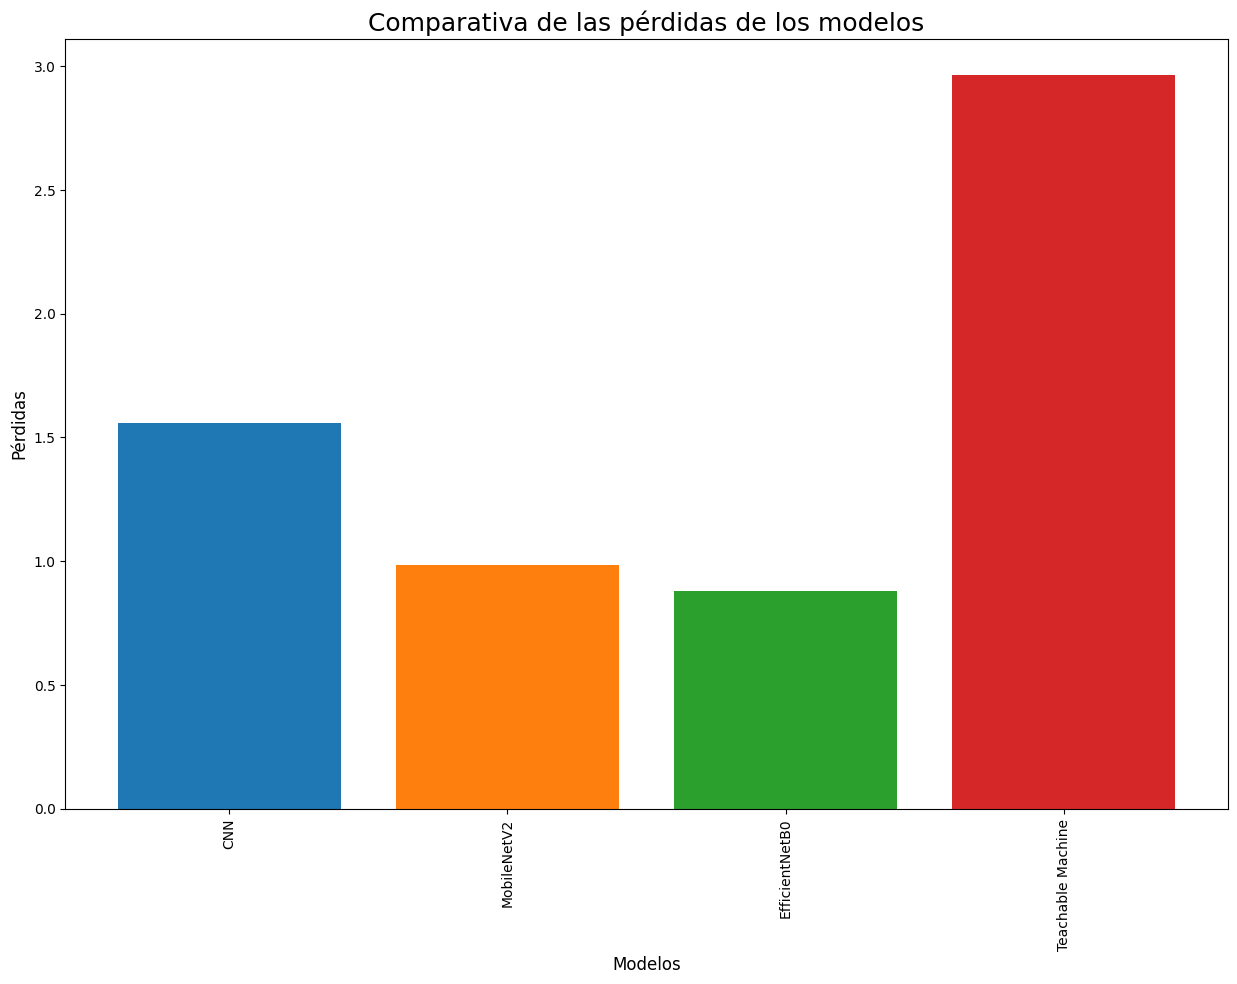

In [25]:
perdidas = [loss_redConv,loss_pre,loss_eff,loss_TM]
modelos = ['CNN','MobileNetV2',
           'EfficientNetB0','Teachable Machine']
colors = ['tab:blue','tab:orange','tab:green','tab:red']
plt.figure(figsize=(15,10))
plt.bar(modelos,perdidas,color=colors)
plt.xticks(rotation=90)
plt.xlabel('Modelos',fontsize=12)
plt.ylabel('Pérdidas',fontsize=12)
plt.title('Comparativa de las pérdidas de los modelos',fontsize=18)
plt.show()

## 8. Selección del mejor modelos

Se entrenaron y evaluaron cuatro modelos de clasificación de imágenes con el objetivo de identificar cual ofrece el mejor rendimiento general al clasificar amenazas aéreas.
Para los modelos de **MobileNetV2** y **EfficientNetB0** se aplicó ***fine-tuning***.

El **modelo** que ofrece mejor rendimiento y menor pérdida es **EfficientNetB0**, su arquitectura optimizada equilibra profundidad, anchura y resolución. Así mismo, mostró una **mejor capacidad** de generalización. En este caso, tiene un mejor desempeño global.

### 8.1 Análisis Comparativo

- **CNN desde cero:**
    - Presenta la menor exactitud y una pérdida alta.
    - Indica un posible **sobreajuste**, esto indicaría que no se dispone un gran volumen de datos, por lo tanto, se descarta como una opción a elegir.

- **MobileNetV2 (con fine-tuning):**
    - Se partió de pesos preentrenados en ImageNet, posteriormente se ajustaron los pesos al conjunto de datos.
    - Su arquitectura liviana la hace eficiente y adecuada para implementaciones en dispositivos móviles.
    - En este caso, ofrece un buen balance entre rendimiento y costo computacional.

- **Teachable Machine:**
    - Presenta una menor adaptación a los datos.